In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_coords_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 831)
(734160, 1)
validation
(101248, 831)
(101248, 1)
test
(100432, 831)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1541121 (5.88 MB)


Trainable params: 1541121 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:29 - loss: 0.0111 - STD: 1.6939e-04 - MAE: 0.0886

 4/74 [>.............................] - ETA: 1s - loss: 0.0133 - STD: 3.3072e-04 - MAE: 0.0874  

 8/74 [==>...........................] - ETA: 1s - loss: 0.0121 - STD: 6.6637e-04 - MAE: 0.0866

11/74 [===>..........................] - ETA: 1s - loss: 0.0117 - STD: 8.1551e-04 - MAE: 0.0836

14/74 [====>.........................] - ETA: 0s - loss: 0.0112 - STD: 0.0010 - MAE: 0.0817    

17/74 [=====>........................] - ETA: 0s - loss: 0.0109 - STD: 0.0012 - MAE: 0.0817

20/74 [=======>......................] - ETA: 0s - loss: 0.0106 - STD: 0.0014 - MAE: 0.0805

24/74 [========>.....................] - ETA: 0s - loss: 0.0104 - STD: 0.0017 - MAE: 0.0792

28/74 [==========>...................] - ETA: 0s - loss: 0.0102 - STD: 0.0021 - MAE: 0.0788

31/74 [===========>..................] - ETA: 0s - loss: 0.0100 - STD: 0.0024 - MAE: 0.0784

34/74 [============>.................] - ETA: 0s - loss: 0.0099 - STD: 0.0027 - MAE: 0.0778

37/74 [==============>...............] - ETA: 0s - loss: 0.0098 - STD: 0.0032 - MAE: 0.0775

40/74 [===============>..............] - ETA: 0s - loss: 0.0097 - STD: 0.0038 - MAE: 0.0772

43/74 [================>.............] - ETA: 0s - loss: 0.0096 - STD: 0.0045 - MAE: 0.0767

47/74 [==================>...........] - ETA: 0s - loss: 0.0095 - STD: 0.0058 - MAE: 0.0762

50/74 [===================>..........] - ETA: 0s - loss: 0.0094 - STD: 0.0070 - MAE: 0.0758

53/74 [====================>.........] - ETA: 0s - loss: 0.0093 - STD: 0.0084 - MAE: 0.0754

56/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0100 - MAE: 0.0751

59/74 [======================>.......] - ETA: 0s - loss: 0.0091 - STD: 0.0117 - MAE: 0.0746

63/74 [========================>.....] - ETA: 0s - loss: 0.0090 - STD: 0.0139 - MAE: 0.0742

66/74 [=========================>....] - ETA: 0s - loss: 0.0089 - STD: 0.0153 - MAE: 0.0738

70/74 [===========================>..] - ETA: 0s - loss: 0.0088 - STD: 0.0169 - MAE: 0.0733

74/74 [==============================] - ETA: 0s - loss: 0.0087 - STD: 0.0182 - MAE: 0.0729

74/74 [==============================] - 4s 33ms/step - loss: 0.0087 - STD: 0.0182 - MAE: 0.0729 - val_loss: 0.0064 - val_STD: 0.0272 - val_MAE: 0.0603


Epoch 2/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0072 - STD: 0.0416 - MAE: 0.0659

 4/74 [>.............................] - ETA: 1s - loss: 0.0071 - STD: 0.0421 - MAE: 0.0656

 8/74 [==>...........................] - ETA: 1s - loss: 0.0070 - STD: 0.0434 - MAE: 0.0653

11/74 [===>..........................] - ETA: 1s - loss: 0.0070 - STD: 0.0443 - MAE: 0.0650

14/74 [====>.........................] - ETA: 1s - loss: 0.0069 - STD: 0.0452 - MAE: 0.0648

17/74 [=====>........................] - ETA: 0s - loss: 0.0069 - STD: 0.0458 - MAE: 0.0647

21/74 [=======>......................] - ETA: 0s - loss: 0.0068 - STD: 0.0461 - MAE: 0.0643

24/74 [========>.....................] - ETA: 0s - loss: 0.0068 - STD: 0.0463 - MAE: 0.0641

27/74 [=========>....................] - ETA: 0s - loss: 0.0068 - STD: 0.0464 - MAE: 0.0639

31/74 [===========>..................] - ETA: 0s - loss: 0.0067 - STD: 0.0466 - MAE: 0.0635

35/74 [=============>................] - ETA: 0s - loss: 0.0066 - STD: 0.0470 - MAE: 0.0632

38/74 [==============>...............] - ETA: 0s - loss: 0.0066 - STD: 0.0473 - MAE: 0.0629

41/74 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0476 - MAE: 0.0626

44/74 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0479 - MAE: 0.0624

47/74 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0484 - MAE: 0.0623

50/74 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0489 - MAE: 0.0622

53/74 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0493 - MAE: 0.0620

56/74 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0497 - MAE: 0.0618

59/74 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0500 - MAE: 0.0616

62/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0504 - MAE: 0.0614

65/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0507 - MAE: 0.0612

68/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0510 - MAE: 0.0610

72/74 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0514 - MAE: 0.0608

74/74 [==============================] - 2s 20ms/step - loss: 0.0062 - STD: 0.0516 - MAE: 0.0606 - val_loss: 0.0049 - val_STD: 0.0427 - val_MAE: 0.0523


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0054 - STD: 0.0599 - MAE: 0.0561

 4/74 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0598 - MAE: 0.0560

 7/74 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0601 - MAE: 0.0558

11/74 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0606 - MAE: 0.0557

15/74 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0610 - MAE: 0.0555

18/74 [======>.......................] - ETA: 0s - loss: 0.0053 - STD: 0.0611 - MAE: 0.0555

21/74 [=======>......................] - ETA: 0s - loss: 0.0053 - STD: 0.0612 - MAE: 0.0554

24/74 [========>.....................] - ETA: 0s - loss: 0.0053 - STD: 0.0613 - MAE: 0.0552

27/74 [=========>....................] - ETA: 0s - loss: 0.0052 - STD: 0.0614 - MAE: 0.0551

30/74 [===========>..................] - ETA: 0s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0550

33/74 [============>.................] - ETA: 0s - loss: 0.0052 - STD: 0.0616 - MAE: 0.0549

36/74 [=============>................] - ETA: 0s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0548

39/74 [==============>...............] - ETA: 0s - loss: 0.0052 - STD: 0.0615 - MAE: 0.0547

42/74 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0616 - MAE: 0.0547

45/74 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0546

48/74 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0617 - MAE: 0.0546

51/74 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0618 - MAE: 0.0546

54/74 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0546

58/74 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0619 - MAE: 0.0544

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0544

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0543

67/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0621 - MAE: 0.0542

70/74 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0622 - MAE: 0.0542

73/74 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0623 - MAE: 0.0542

74/74 [==============================] - 2s 21ms/step - loss: 0.0051 - STD: 0.0623 - MAE: 0.0541 - val_loss: 0.0043 - val_STD: 0.0489 - val_MAE: 0.0482


Epoch 4/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0046 - STD: 0.0631 - MAE: 0.0513

 4/74 [>.............................] - ETA: 1s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0520

 7/74 [=>............................] - ETA: 1s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0518

10/74 [===>..........................] - ETA: 1s - loss: 0.0047 - STD: 0.0641 - MAE: 0.0516

14/74 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0645 - MAE: 0.0521

18/74 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0650 - MAE: 0.0521

21/74 [=======>......................] - ETA: 0s - loss: 0.0048 - STD: 0.0649 - MAE: 0.0521

25/74 [=========>....................] - ETA: 0s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0519

28/74 [==========>...................] - ETA: 0s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0518

31/74 [===========>..................] - ETA: 0s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0517

35/74 [=============>................] - ETA: 0s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0517

39/74 [==============>...............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0517

42/74 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0517

46/74 [=================>............] - ETA: 0s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0517

50/74 [===================>..........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0516

54/74 [====================>.........] - ETA: 0s - loss: 0.0047 - STD: 0.0657 - MAE: 0.0514

58/74 [======================>.......] - ETA: 0s - loss: 0.0047 - STD: 0.0658 - MAE: 0.0515

62/74 [========================>.....] - ETA: 0s - loss: 0.0047 - STD: 0.0660 - MAE: 0.0514

66/74 [=========================>....] - ETA: 0s - loss: 0.0047 - STD: 0.0659 - MAE: 0.0514

70/74 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0513

74/74 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0512

74/74 [==============================] - 1s 20ms/step - loss: 0.0046 - STD: 0.0661 - MAE: 0.0512 - val_loss: 0.0039 - val_STD: 0.0559 - val_MAE: 0.0469


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0706 - MAE: 0.0504

 4/74 [>.............................] - ETA: 1s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0497

 8/74 [==>...........................] - ETA: 1s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

11/74 [===>..........................] - ETA: 1s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0498

14/74 [====>.........................] - ETA: 1s - loss: 0.0045 - STD: 0.0684 - MAE: 0.0506

18/74 [======>.......................] - ETA: 0s - loss: 0.0045 - STD: 0.0679 - MAE: 0.0503

21/74 [=======>......................] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0505

25/74 [=========>....................] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0503

28/74 [==========>...................] - ETA: 0s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0504

31/74 [===========>..................] - ETA: 0s - loss: 0.0045 - STD: 0.0676 - MAE: 0.0502

34/74 [============>.................] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0502

37/74 [==============>...............] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0500

40/74 [===============>..............] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0501

43/74 [================>.............] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

46/74 [=================>............] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

50/74 [===================>..........] - ETA: 0s - loss: 0.0045 - STD: 0.0680 - MAE: 0.0501

53/74 [====================>.........] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

56/74 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0501

60/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0679 - MAE: 0.0500

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0499

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0499

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0498

74/74 [==============================] - 1s 19ms/step - loss: 0.0044 - STD: 0.0682 - MAE: 0.0498 - val_loss: 0.0041 - val_STD: 0.0523 - val_MAE: 0.0458


Epoch 6/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0042 - STD: 0.0651 - MAE: 0.0475

 4/74 [>.............................] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0482

 7/74 [=>............................] - ETA: 1s - loss: 0.0043 - STD: 0.0697 - MAE: 0.0493

11/74 [===>..........................] - ETA: 1s - loss: 0.0045 - STD: 0.0687 - MAE: 0.0500

15/74 [=====>........................] - ETA: 1s - loss: 0.0045 - STD: 0.0686 - MAE: 0.0499

18/74 [======>.......................] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

21/74 [=======>......................] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

25/74 [=========>....................] - ETA: 0s - loss: 0.0044 - STD: 0.0682 - MAE: 0.0496

29/74 [==========>...................] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0496

33/74 [============>.................] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

36/74 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0494

39/74 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

42/74 [================>.............] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0492

45/74 [=================>............] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491

48/74 [==================>...........] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0490

51/74 [===================>..........] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

54/74 [====================>.........] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0491

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0492

61/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0492

69/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491

72/74 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491

74/74 [==============================] - 1s 20ms/step - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491 - val_loss: 0.0036 - val_STD: 0.0583 - val_MAE: 0.0453


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0728 - MAE: 0.0489

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0479

 7/74 [=>............................] - ETA: 1s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0481

10/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0700 - MAE: 0.0483

13/74 [====>.........................] - ETA: 1s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0486

16/74 [=====>........................] - ETA: 1s - loss: 0.0043 - STD: 0.0703 - MAE: 0.0490

20/74 [=======>......................] - ETA: 0s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0491

23/74 [========>.....................] - ETA: 0s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0491

26/74 [=========>....................] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0491

29/74 [==========>...................] - ETA: 0s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0491

32/74 [===========>..................] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

35/74 [=============>................] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

39/74 [==============>...............] - ETA: 0s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

43/74 [================>.............] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0489

46/74 [=================>............] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0489

49/74 [==================>...........] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0488

53/74 [====================>.........] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0487

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0487

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0486

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0485

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0485

74/74 [==============================] - 1s 19ms/step - loss: 0.0042 - STD: 0.0700 - MAE: 0.0485 - val_loss: 0.0038 - val_STD: 0.0539 - val_MAE: 0.0446


Epoch 8/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0665 - MAE: 0.0468

 4/74 [>.............................] - ETA: 1s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0475

 8/74 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

12/74 [===>..........................] - ETA: 1s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0477

15/74 [=====>........................] - ETA: 1s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0478

18/74 [======>.......................] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0477

22/74 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0476

26/74 [=========>....................] - ETA: 0s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0478

29/74 [==========>...................] - ETA: 0s - loss: 0.0041 - STD: 0.0706 - MAE: 0.0478

32/74 [===========>..................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0479

36/74 [=============>................] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0477

40/74 [===============>..............] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0477

44/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

48/74 [==================>...........] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0477

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

57/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0710 - MAE: 0.0478

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0477

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0477

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0708 - MAE: 0.0477

74/74 [==============================] - 2s 20ms/step - loss: 0.0041 - STD: 0.0708 - MAE: 0.0477 - val_loss: 0.0035 - val_STD: 0.0569 - val_MAE: 0.0435


Epoch 9/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0469

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

 8/74 [==>...........................] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

11/74 [===>..........................] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0475

15/74 [=====>........................] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

19/74 [======>.......................] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

23/74 [========>.....................] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

27/74 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

30/74 [===========>..................] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0473

33/74 [============>.................] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

36/74 [=============>................] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

39/74 [==============>...............] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0473

42/74 [================>.............] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0475

45/74 [=================>............] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0476

48/74 [==================>...........] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0477

51/74 [===================>..........] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0477

54/74 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0477

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0476

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0476

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0475

74/74 [==============================] - 1s 20ms/step - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474 - val_loss: 0.0034 - val_STD: 0.0605 - val_MAE: 0.0433


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0462

 4/74 [>.............................] - ETA: 1s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0461

 8/74 [==>...........................] - ETA: 1s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0462

11/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0467

14/74 [====>.........................] - ETA: 1s - loss: 0.0040 - STD: 0.0727 - MAE: 0.0471

18/74 [======>.......................] - ETA: 0s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

21/74 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

24/74 [========>.....................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

28/74 [==========>...................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

31/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

34/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

38/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

41/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

45/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

52/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

55/74 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0468

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0469

66/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

69/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0468

74/74 [==============================] - 1s 19ms/step - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467 - val_loss: 0.0035 - val_STD: 0.0571 - val_MAE: 0.0431


Epoch 11/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0691 - MAE: 0.0455

 4/74 [>.............................] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0491

 8/74 [==>...........................] - ETA: 1s - loss: 0.0041 - STD: 0.0716 - MAE: 0.0481

12/74 [===>..........................] - ETA: 0s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0478

15/74 [=====>........................] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0477

19/74 [======>.......................] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0476

22/74 [=======>......................] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

25/74 [=========>....................] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

28/74 [==========>...................] - ETA: 0s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0473

32/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0471

36/74 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

39/74 [==============>...............] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0470

42/74 [================>.............] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

45/74 [=================>............] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0470

48/74 [==================>...........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

51/74 [===================>..........] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0469

54/74 [====================>.........] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0469

58/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

62/74 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0467

65/74 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

68/74 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

71/74 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0466

74/74 [==============================] - 1s 20ms/step - loss: 0.0039 - STD: 0.0723 - MAE: 0.0466 - val_loss: 0.0033 - val_STD: 0.0633 - val_MAE: 0.0430


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0037 - STD: 0.0764 - MAE: 0.0465

 5/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0742 - MAE: 0.0478

 8/74 [==>...........................] - ETA: 1s - loss: 0.0042 - STD: 0.0722 - MAE: 0.0484

11/74 [===>..........................] - ETA: 1s - loss: 0.0042 - STD: 0.0716 - MAE: 0.0482

14/74 [====>.........................] - ETA: 1s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0479

17/74 [=====>........................] - ETA: 0s - loss: 0.0041 - STD: 0.0714 - MAE: 0.0482

20/74 [=======>......................] - ETA: 0s - loss: 0.0042 - STD: 0.0708 - MAE: 0.0486

24/74 [========>.....................] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0525

28/74 [==========>...................] - ETA: 0s - loss: 0.0055 - STD: 0.0669 - MAE: 0.0554

32/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0632 - MAE: 0.0557

35/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0618 - MAE: 0.0565

39/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0567

43/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0585 - MAE: 0.0569

46/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0581 - MAE: 0.0567

50/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0581 - MAE: 0.0566

53/74 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0564

56/74 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0584 - MAE: 0.0560

60/74 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0588 - MAE: 0.0556

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0592 - MAE: 0.0552

68/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0598 - MAE: 0.0548

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0601 - MAE: 0.0545

74/74 [==============================] - 1s 19ms/step - loss: 0.0051 - STD: 0.0607 - MAE: 0.0542 - val_loss: 0.0036 - val_STD: 0.0590 - val_MAE: 0.0441


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0468

 4/74 [>.............................] - ETA: 1s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0476

 7/74 [=>............................] - ETA: 1s - loss: 0.0040 - STD: 0.0732 - MAE: 0.0475

11/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0472

14/74 [====>.........................] - ETA: 1s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0472

17/74 [=====>........................] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0471

21/74 [=======>......................] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0469

24/74 [========>.....................] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0469

27/74 [=========>....................] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0468

30/74 [===========>..................] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

33/74 [============>.................] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0467

36/74 [=============>................] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0467

40/74 [===============>..............] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0466

43/74 [================>.............] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0465

46/74 [=================>............] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0464

50/74 [===================>..........] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0464

54/74 [====================>.........] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0462

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0461

74/74 [==============================] - 1s 19ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0461 - val_loss: 0.0033 - val_STD: 0.0607 - val_MAE: 0.0425


Epoch 14/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0451

14/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

17/74 [=====>........................] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

21/74 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

24/74 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

28/74 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

32/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454

36/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0454

39/74 [==============>...............] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0454

43/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

47/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

51/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

55/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

74/74 [==============================] - 1s 20ms/step - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0631 - val_MAE: 0.0424


Epoch 15/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0757 - MAE: 0.0456

 5/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

 8/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

15/74 [=====>........................] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0452

19/74 [======>.......................] - ETA: 0s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

22/74 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0453

25/74 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0453

29/74 [==========>...................] - ETA: 0s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

32/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

35/74 [=============>................] - ETA: 0s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0453

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

42/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0452

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0452

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0452

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0453

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0453

74/74 [==============================] - 1s 20ms/step - loss: 0.0037 - STD: 0.0742 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0610 - val_MAE: 0.0419


Epoch 16/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0449

 7/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0452

11/74 [===>..........................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

14/74 [====>.........................] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

17/74 [=====>........................] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

21/74 [=======>......................] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

24/74 [========>.....................] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0452

28/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0452

31/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

34/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0451

56/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - 1s 20ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453 - val_loss: 0.0032 - val_STD: 0.0623 - val_MAE: 0.0417


Epoch 17/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0736 - MAE: 0.0444

 4/74 [>.............................] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0451

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

15/74 [=====>........................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0452

19/74 [======>.......................] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

23/74 [========>.....................] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0451

27/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0450

31/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0450

35/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0451

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0452

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0452

44/74 [================>.............] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0452

47/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

50/74 [===================>..........] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

53/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0451

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451

74/74 [==============================] - 1s 20ms/step - loss: 0.0036 - STD: 0.0741 - MAE: 0.0451 - val_loss: 0.0032 - val_STD: 0.0635 - val_MAE: 0.0416


Epoch 18/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0442

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0447

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

15/74 [=====>........................] - ETA: 0s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0452

19/74 [======>.......................] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

23/74 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0451

26/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

29/74 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

32/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

36/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

40/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

43/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

47/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0448

50/74 [===================>..........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

53/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0447

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0448

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449

74/74 [==============================] - 1s 19ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0449 - val_loss: 0.0033 - val_STD: 0.0588 - val_MAE: 0.0415


Epoch 19/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0713 - MAE: 0.0441

 5/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0450

 8/74 [==>...........................] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0448

11/74 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

14/74 [====>.........................] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0446

17/74 [=====>........................] - ETA: 0s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0449

20/74 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

24/74 [========>.....................] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0449

27/74 [=========>....................] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

30/74 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0450

33/74 [============>.................] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

36/74 [=============>................] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

39/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

42/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

46/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

49/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

53/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

74/74 [==============================] - 2s 20ms/step - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447 - val_loss: 0.0031 - val_STD: 0.0623 - val_MAE: 0.0410


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

 5/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0442

 9/74 [==>...........................] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0441

13/74 [====>.........................] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0442

16/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0441

19/74 [======>.......................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

22/74 [=======>......................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

25/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0441

28/74 [==========>...................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0442

31/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

35/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0442

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0446

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0447

44/74 [================>.............] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0449

48/74 [==================>...........] - ETA: 0s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0451

52/74 [====================>.........] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0453

56/74 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

59/74 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0466

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0725 - MAE: 0.0470

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0473

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0474

74/74 [==============================] - 1s 19ms/step - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475 - val_loss: 0.0040 - val_STD: 0.0460 - val_MAE: 0.0454


Epoch 21/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0585 - MAE: 0.0477

 5/74 [=>............................] - ETA: 1s - loss: 0.0039 - STD: 0.0645 - MAE: 0.0471

 9/74 [==>...........................] - ETA: 1s - loss: 0.0039 - STD: 0.0665 - MAE: 0.0470

12/74 [===>..........................] - ETA: 1s - loss: 0.0038 - STD: 0.0678 - MAE: 0.0468

15/74 [=====>........................] - ETA: 1s - loss: 0.0038 - STD: 0.0688 - MAE: 0.0465

19/74 [======>.......................] - ETA: 0s - loss: 0.0038 - STD: 0.0699 - MAE: 0.0462

23/74 [========>.....................] - ETA: 0s - loss: 0.0037 - STD: 0.0707 - MAE: 0.0459

27/74 [=========>....................] - ETA: 0s - loss: 0.0037 - STD: 0.0711 - MAE: 0.0457

31/74 [===========>..................] - ETA: 0s - loss: 0.0037 - STD: 0.0716 - MAE: 0.0455

34/74 [============>.................] - ETA: 0s - loss: 0.0037 - STD: 0.0718 - MAE: 0.0453

38/74 [==============>...............] - ETA: 0s - loss: 0.0036 - STD: 0.0720 - MAE: 0.0451

41/74 [===============>..............] - ETA: 0s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0451

45/74 [=================>............] - ETA: 0s - loss: 0.0036 - STD: 0.0724 - MAE: 0.0450

48/74 [==================>...........] - ETA: 0s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0449

52/74 [====================>.........] - ETA: 0s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0448

56/74 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0448

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0447

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0446

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0446

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

74/74 [==============================] - 1s 19ms/step - loss: 0.0036 - STD: 0.0737 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0632 - val_MAE: 0.0409


Epoch 22/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0437

 5/74 [=>............................] - ETA: 1s - loss: 0.0037 - STD: 0.0766 - MAE: 0.0455

 8/74 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0459

11/74 [===>..........................] - ETA: 1s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0469

15/74 [=====>........................] - ETA: 0s - loss: 0.0046 - STD: 0.0722 - MAE: 0.0503

18/74 [======>.......................] - ETA: 0s - loss: 0.0048 - STD: 0.0711 - MAE: 0.0519

22/74 [=======>......................] - ETA: 0s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0530

25/74 [=========>....................] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0528

28/74 [==========>...................] - ETA: 0s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0529

32/74 [===========>..................] - ETA: 0s - loss: 0.0049 - STD: 0.0646 - MAE: 0.0526

35/74 [=============>................] - ETA: 0s - loss: 0.0049 - STD: 0.0641 - MAE: 0.0524

38/74 [==============>...............] - ETA: 0s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0522

41/74 [===============>..............] - ETA: 0s - loss: 0.0047 - STD: 0.0638 - MAE: 0.0518

44/74 [================>.............] - ETA: 0s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0515

47/74 [==================>...........] - ETA: 0s - loss: 0.0046 - STD: 0.0645 - MAE: 0.0511

50/74 [===================>..........] - ETA: 0s - loss: 0.0046 - STD: 0.0649 - MAE: 0.0508

53/74 [====================>.........] - ETA: 0s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0505

56/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0502

59/74 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0662 - MAE: 0.0500

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0497

65/74 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0495

68/74 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0493

71/74 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0491

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0489

74/74 [==============================] - 1s 20ms/step - loss: 0.0042 - STD: 0.0678 - MAE: 0.0489 - val_loss: 0.0031 - val_STD: 0.0628 - val_MAE: 0.0414


Epoch 23/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0444

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0439

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0438

15/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0439

19/74 [======>.......................] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0439

23/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

26/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

30/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

33/74 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

37/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

40/74 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

44/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

48/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

52/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

55/74 [=====================>........] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0437 - val_loss: 0.0031 - val_STD: 0.0630 - val_MAE: 0.0406


Epoch 24/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0429

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

11/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

18/74 [======>.......................] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

22/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

25/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

28/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

32/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

36/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

40/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0434

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434 - val_loss: 0.0032 - val_STD: 0.0609 - val_MAE: 0.0410


Epoch 25/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0430

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

12/74 [===>..........................] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

16/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

20/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

24/74 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

27/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

30/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

34/74 [============>.................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

37/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

40/74 [===============>..............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

46/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

50/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

54/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

74/74 [==============================] - 1s 20ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0431 - val_loss: 0.0030 - val_STD: 0.0659 - val_MAE: 0.0409


Epoch 26/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0787 - MAE: 0.0444

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0437

 7/74 [=>............................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

11/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

14/74 [====>.........................] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

17/74 [=====>........................] - ETA: 0s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

20/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0436

23/74 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0436

27/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

31/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

39/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

43/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

47/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

51/74 [===================>..........] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

55/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433 - val_loss: 0.0030 - val_STD: 0.0645 - val_MAE: 0.0404


Epoch 27/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0431

 4/74 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0768 - MAE: 0.0448

 7/74 [=>............................] - ETA: 1s - loss: 0.0036 - STD: 0.0763 - MAE: 0.0444

10/74 [===>..........................] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0443

14/74 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0446

17/74 [=====>........................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

20/74 [=======>......................] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

23/74 [========>.....................] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0443

27/74 [=========>....................] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

31/74 [===========>..................] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

35/74 [=============>................] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

39/74 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

43/74 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

47/74 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

51/74 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

54/74 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0436

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435 - val_loss: 0.0031 - val_STD: 0.0684 - val_MAE: 0.0420


Epoch 28/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0819 - MAE: 0.0452

 5/74 [=>............................] - ETA: 1s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0434

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0431

17/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

20/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0430

24/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0430

28/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

31/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

35/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0430

39/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

42/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

45/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0431

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

53/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435 - val_loss: 0.0030 - val_STD: 0.0653 - val_MAE: 0.0409


Epoch 29/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0791 - MAE: 0.0443

 5/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0431

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

15/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

18/74 [======>.......................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

21/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

25/74 [=========>....................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

28/74 [==========>...................] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

31/74 [===========>..................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

35/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

38/74 [==============>...............] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

42/74 [================>.............] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

45/74 [=================>............] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

49/74 [==================>...........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

52/74 [====================>.........] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0431

56/74 [=====================>........] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0432

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430 - val_loss: 0.0031 - val_STD: 0.0616 - val_MAE: 0.0402


Epoch 30/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0744 - MAE: 0.0414

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

16/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

19/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

22/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

25/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

28/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

32/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

36/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

74/74 [==============================] - 1s 20ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0657 - val_MAE: 0.0401


Epoch 31/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0793 - MAE: 0.0427

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0422

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

10/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

16/74 [=====>........................] - ETA: 1s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0430

19/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0429

22/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

26/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

30/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

33/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

36/74 [=============>................] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

39/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0429

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0429

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

54/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

74/74 [==============================] - 1s 20ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0396


Epoch 32/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0752 - MAE: 0.0416

 5/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

13/74 [====>.........................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

16/74 [=====>........................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

20/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

24/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

27/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

30/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

74/74 [==============================] - 1s 19ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0624 - val_MAE: 0.0398


Epoch 33/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0416

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

15/74 [=====>........................] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

18/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

22/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

25/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

28/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

31/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

48/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

51/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

74/74 [==============================] - 1s 19ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426 - val_loss: 0.0031 - val_STD: 0.0598 - val_MAE: 0.0399


Epoch 34/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0718 - MAE: 0.0426

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0429

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0429

14/74 [====>.........................] - ETA: 1s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0429

17/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0429

21/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0429

24/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0427

27/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0427

31/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0427

34/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

37/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

40/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0425

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - 1s 19ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430 - val_loss: 0.0030 - val_STD: 0.0636 - val_MAE: 0.0414


Epoch 35/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0443

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0436

 7/74 [=>............................] - ETA: 1s - loss: 0.0033 - STD: 0.0740 - MAE: 0.0430

11/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0744 - MAE: 0.0429

14/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0429

18/74 [======>.......................] - ETA: 0s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0426

22/74 [=======>......................] - ETA: 0s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0426

25/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0425

28/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0424

31/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0424

35/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0425

38/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

41/74 [===============>..............] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

45/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

49/74 [==================>...........] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

52/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0766 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0624 - val_MAE: 0.0395


Epoch 36/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0420

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

14/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

17/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

21/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

24/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

27/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0421

30/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0421

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

47/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

51/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

54/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0033 - val_STD: 0.0599 - val_MAE: 0.0410


Epoch 37/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0035 - STD: 0.0726 - MAE: 0.0424

 4/74 [>.............................] - ETA: 1s - loss: 0.0035 - STD: 0.0772 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

12/74 [===>..........................] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

16/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

20/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

23/74 [========>.....................] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

26/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

30/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

33/74 [============>.................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

36/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

39/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

43/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

55/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

74/74 [==============================] - 1s 20ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0393


Epoch 38/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0414

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

16/74 [=====>........................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

19/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

23/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

27/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

30/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0422

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

74/74 [==============================] - 1s 19ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0662 - val_MAE: 0.0400


Epoch 39/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0798 - MAE: 0.0424

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

 9/74 [==>...........................] - ETA: 1s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

19/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

22/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

25/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

31/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

35/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

38/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

42/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - 1s 20ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0395


Epoch 40/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0411

 4/74 [>.............................] - ETA: 1s - loss: 0.0033 - STD: 0.0786 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

12/74 [===>..........................] - ETA: 1s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

15/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

18/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

21/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

25/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

29/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

37/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

41/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

45/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0688 - val_MAE: 0.0419


Epoch 41/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0814 - MAE: 0.0442

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0425

12/74 [===>..........................] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

19/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0421

23/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

26/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0421

30/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

33/74 [============>.................] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

40/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

47/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

50/74 [===================>..........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

53/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

56/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0643 - val_MAE: 0.0394


Epoch 42/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

13/74 [====>.........................] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

17/74 [=====>........................] - ETA: 0s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0429

20/74 [=======>......................] - ETA: 0s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

23/74 [========>.....................] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

26/74 [=========>....................] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

29/74 [==========>...................] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

32/74 [===========>..................] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

36/74 [=============>................] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

39/74 [==============>...............] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

42/74 [================>.............] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

46/74 [=================>............] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

50/74 [===================>..........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

53/74 [====================>.........] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

56/74 [=====================>........] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

74/74 [==============================] - 1s 20ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0396


Epoch 43/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0417

 5/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0414

 9/74 [==>...........................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

13/74 [====>.........................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

17/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

20/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

23/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

27/74 [=========>....................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

30/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0415

38/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

41/74 [===============>..............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

44/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

48/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

55/74 [=====================>........] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0035 - val_STD: 0.0586 - val_MAE: 0.0420


Epoch 44/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0710 - MAE: 0.0423

 5/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

13/74 [====>.........................] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

20/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

24/74 [========>.....................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

28/74 [==========>...................] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

32/74 [===========>..................] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

36/74 [=============>................] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

39/74 [==============>...............] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

43/74 [================>.............] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

46/74 [=================>............] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

49/74 [==================>...........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

52/74 [====================>.........] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0621 - val_MAE: 0.0390


Epoch 45/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0761 - MAE: 0.0403

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0421

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0417

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

16/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

19/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

22/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

74/74 [==============================] - 1s 20ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0404


Epoch 46/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0817 - MAE: 0.0432

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0415

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

10/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0419

13/74 [====>.........................] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

17/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

21/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

34/74 [============>.................] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

37/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

40/74 [===============>..............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

43/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

74/74 [==============================] - 1s 20ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415 - val_loss: 0.0033 - val_STD: 0.0589 - val_MAE: 0.0406


Epoch 47/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0720 - MAE: 0.0414

 4/74 [>.............................] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0414

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

11/74 [===>..........................] - ETA: 1s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

15/74 [=====>........................] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

18/74 [======>.......................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

21/74 [=======>......................] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

32/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

36/74 [=============>................] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

40/74 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

44/74 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

48/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

55/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0622 - val_MAE: 0.0389


Epoch 48/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0404

 4/74 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

 7/74 [=>............................] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

10/74 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

13/74 [====>.........................] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0412

17/74 [=====>........................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

21/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

24/74 [========>.....................] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

27/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

31/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

35/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

39/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

52/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

56/74 [=====================>........] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

74/74 [==============================] - 1s 19ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411 - val_loss: 0.0041 - val_STD: 0.0544 - val_MAE: 0.0455


Epoch 49/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0458

 4/74 [>.............................] - ETA: 1s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0427

 7/74 [=>............................] - ETA: 1s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0421

11/74 [===>..........................] - ETA: 1s - loss: 0.0032 - STD: 0.0756 - MAE: 0.0422

15/74 [=====>........................] - ETA: 0s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0418

18/74 [======>.......................] - ETA: 0s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

21/74 [=======>......................] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

25/74 [=========>....................] - ETA: 0s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0414

28/74 [==========>...................] - ETA: 0s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

32/74 [===========>..................] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

36/74 [=============>................] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

39/74 [==============>...............] - ETA: 0s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

42/74 [================>.............] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

46/74 [=================>............] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

49/74 [==================>...........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

53/74 [====================>.........] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

74/74 [==============================] - 1s 19ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416 - val_loss: 0.0044 - val_STD: 0.0518 - val_MAE: 0.0471


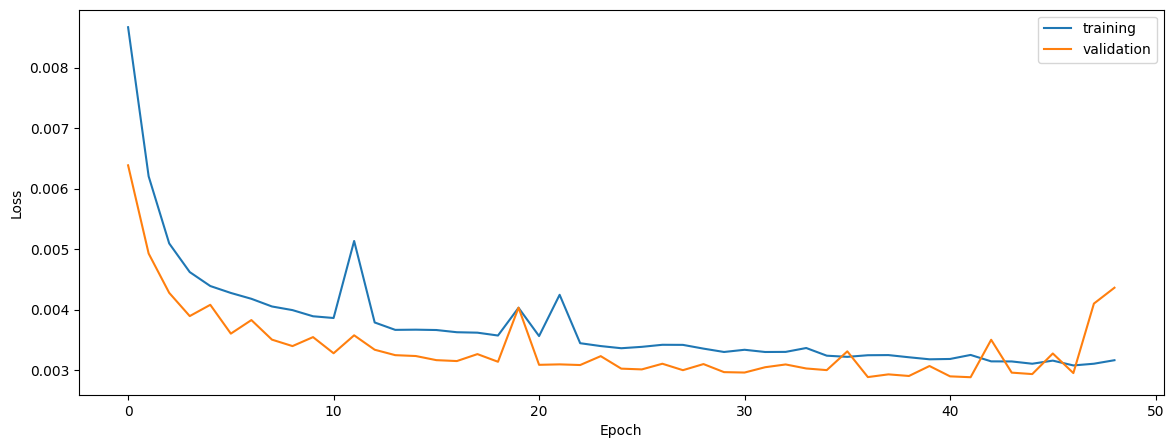

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8170713134668542
0.8155760731980818
0.8096693152757479


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8170713134668542
0.8155760731980818
0.8096693152757479


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.8138633029650532
0.8223064901747453
0.806124345900897


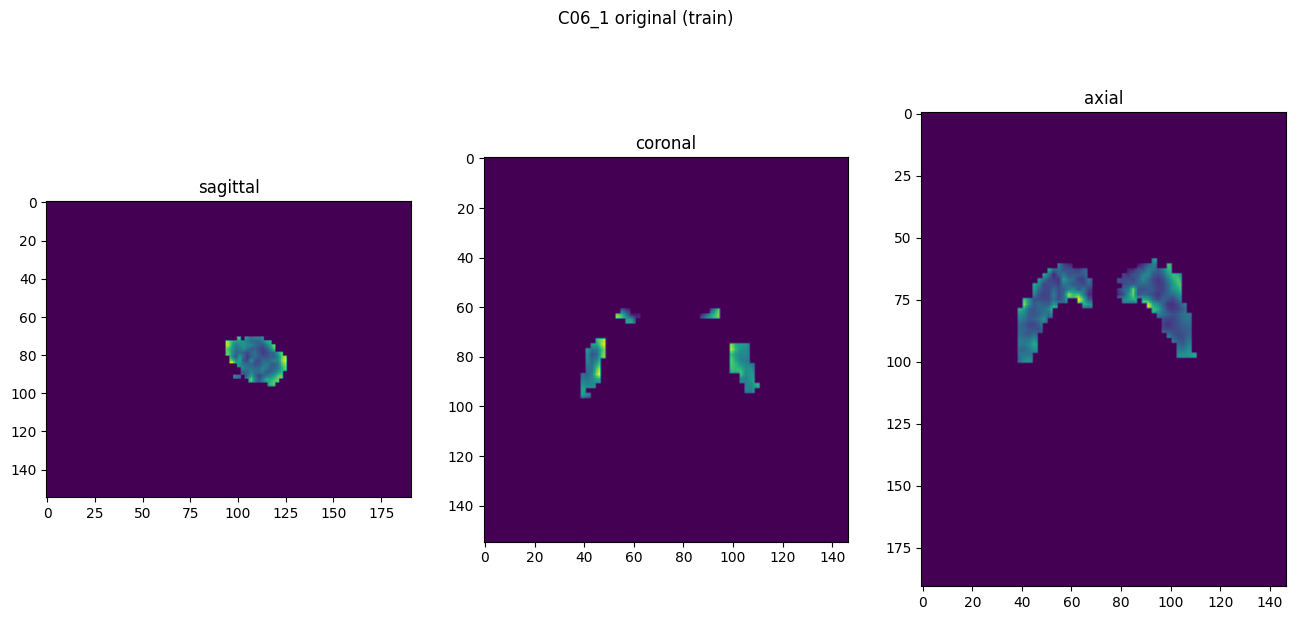

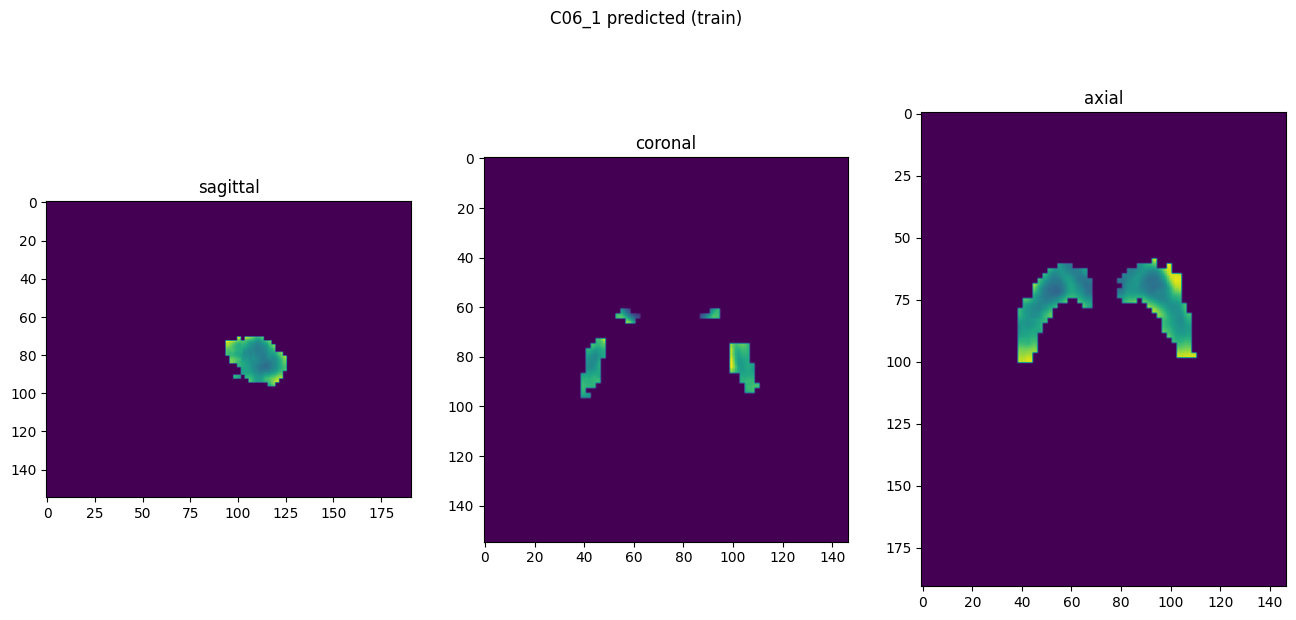

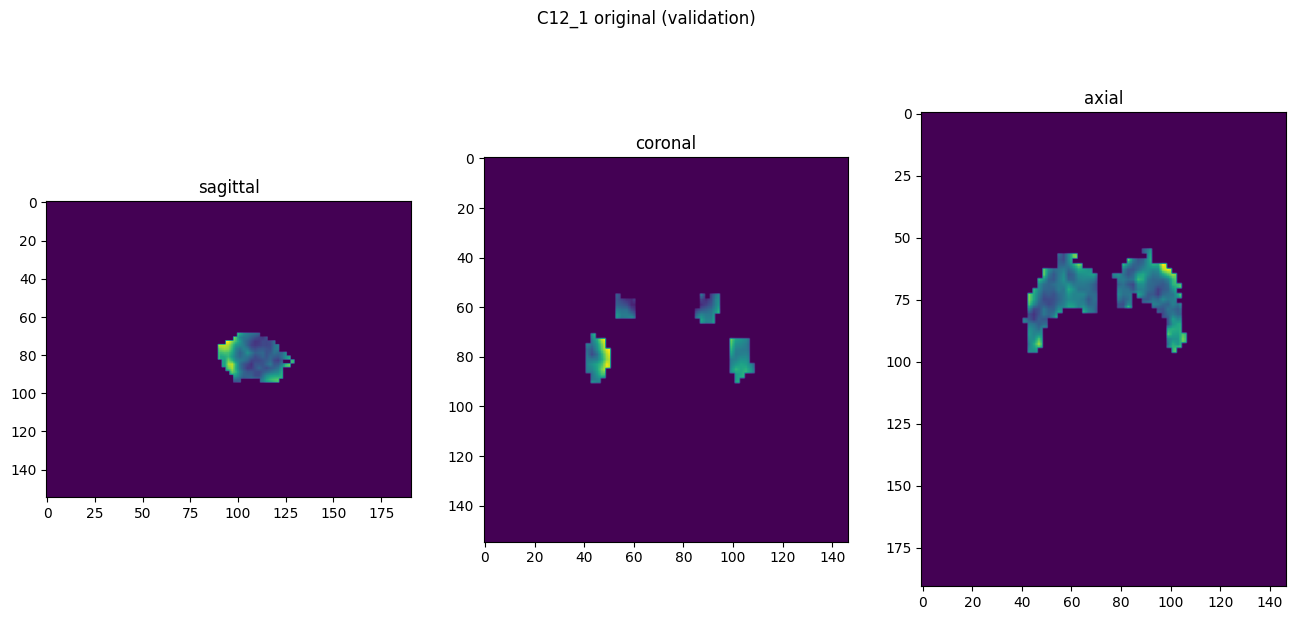

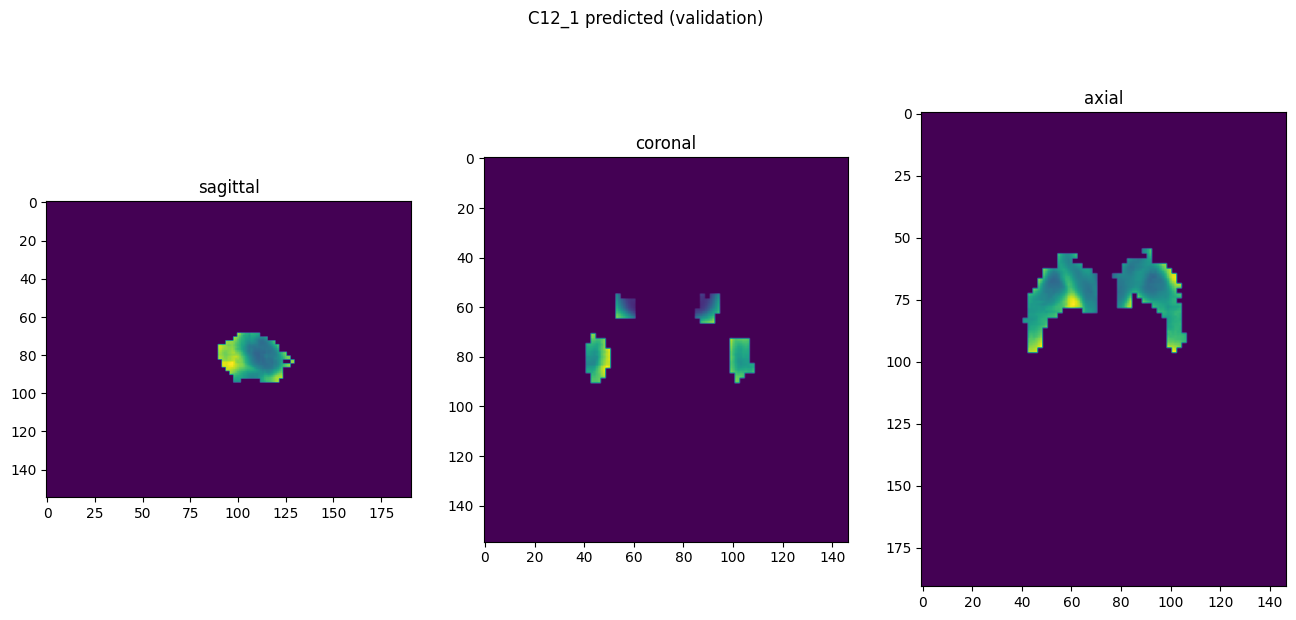

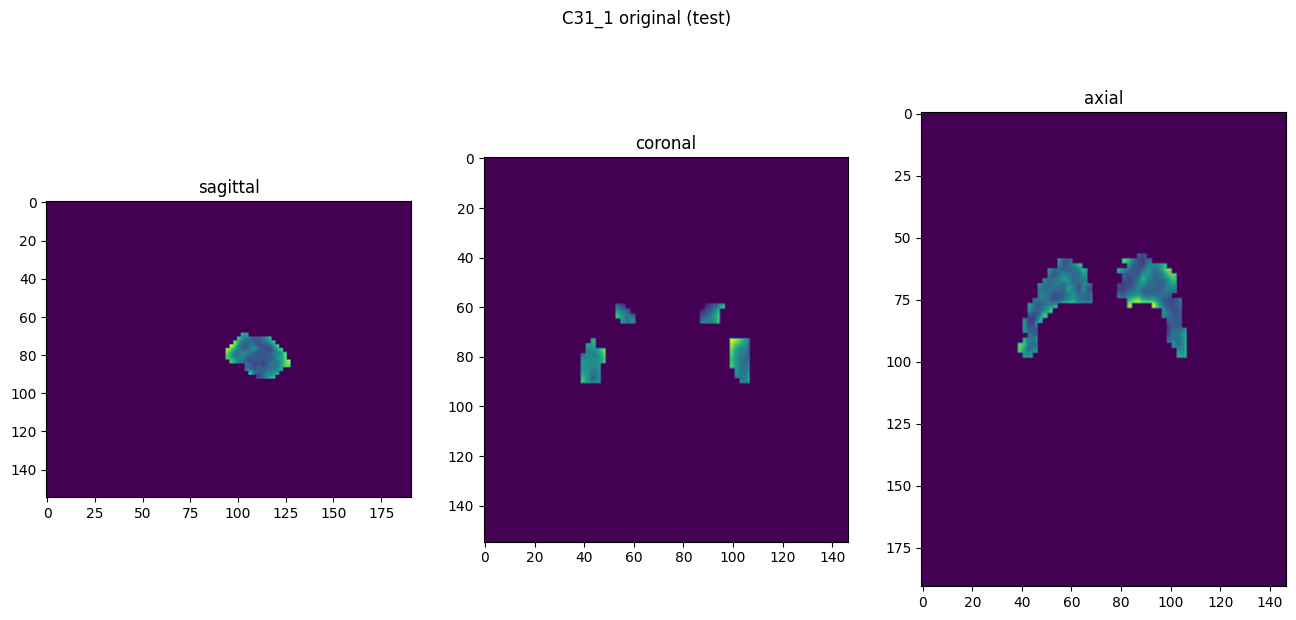

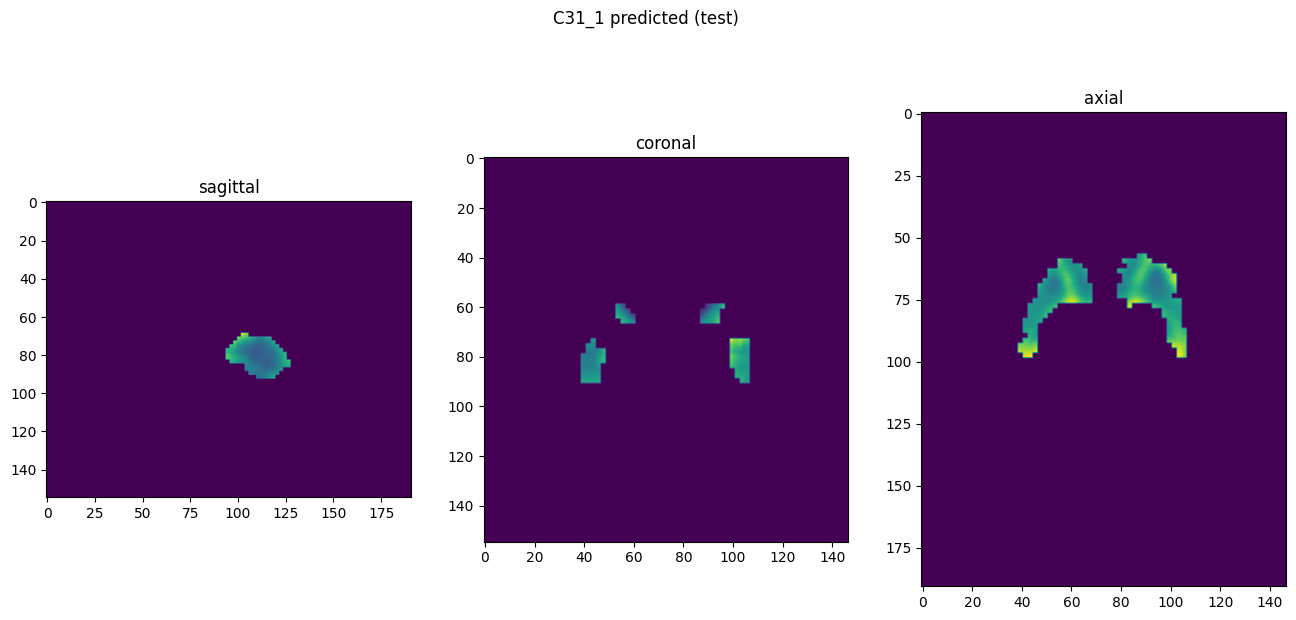

In [10]:
showResults(model, gen, threshold=None, background=False)